### Preview dataset and some examples with images

Dataset Information:
Total number of images: 2527

Number of images per category:
category
paper        594
glass        501
plastic      482
metal        410
cardboard    403
trash        137
Name: count, dtype: int64

First 5 rows of the dataset:
                                          image_path category
0  data/garbage classification/Garbage classifica...  plastic
1  data/garbage classification/Garbage classifica...  plastic
2  data/garbage classification/Garbage classifica...  plastic
3  data/garbage classification/Garbage classifica...  plastic
4  data/garbage classification/Garbage classifica...  plastic


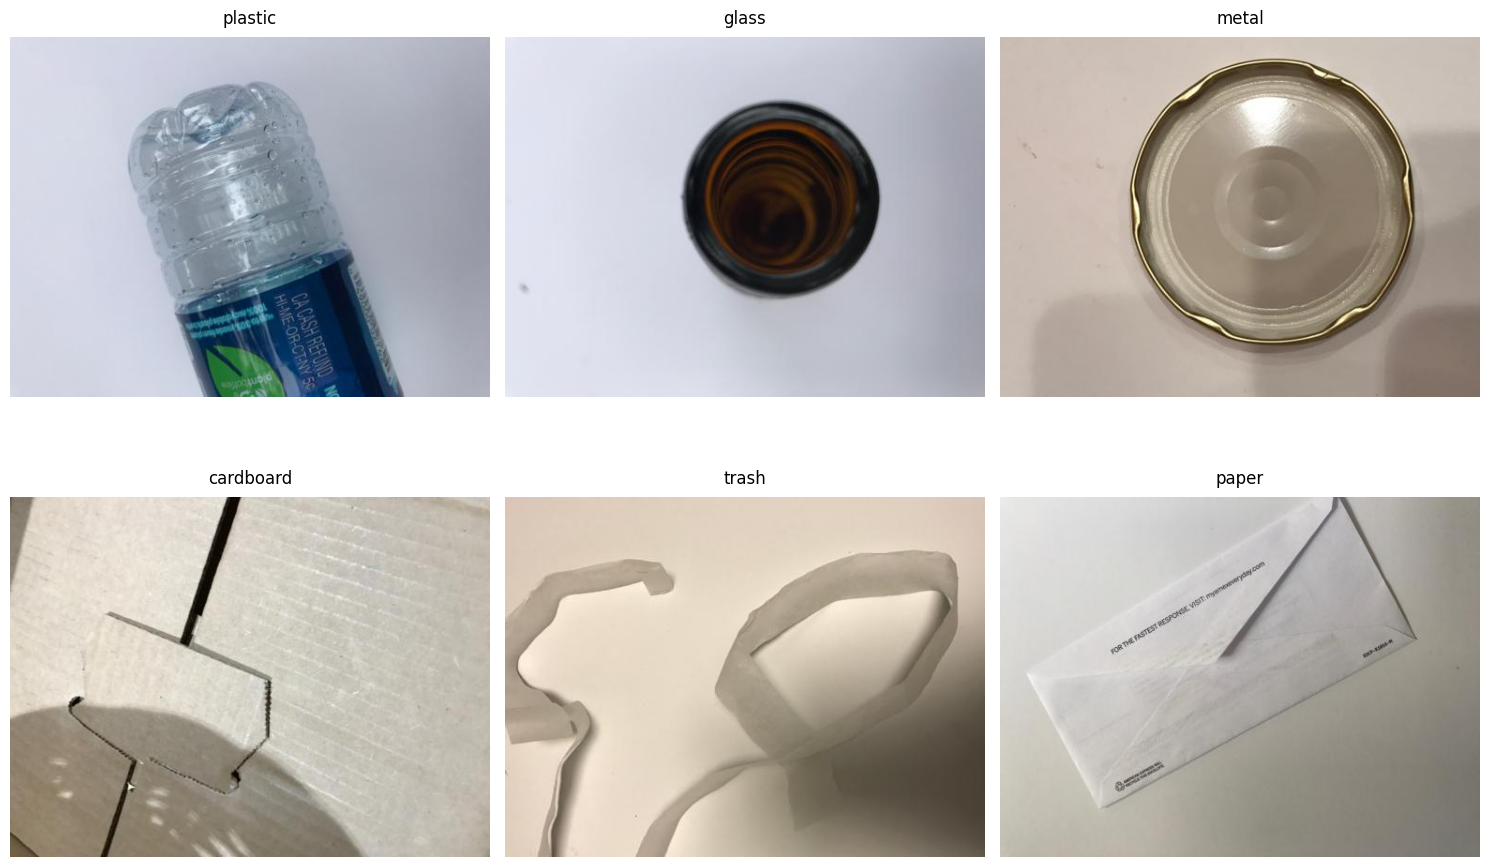


Image Statistics:

Image dimensions statistics:
        width  height
count  2527.0  2527.0
mean    512.0   384.0
std       0.0     0.0
min     512.0   384.0
25%     512.0   384.0
50%     512.0   384.0
75%     512.0   384.0
max     512.0   384.0


In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

import kagglehub



# Set up matplotlib for better visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]

# Define the base path to the dataset
base_path = Path('data/garbage classification/Garbage classification')

# Create lists to store the data
image_paths = []
categories = []

# Walk through the directory and collect all image paths and their categories
for category in os.listdir(base_path):
    category_path = base_path / category
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            if image_file.endswith('.jpg'):
                image_paths.append(str(category_path / image_file))
                categories.append(category)

# Create the DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'category': categories
})

# Display basic information about the dataset
print("Dataset Information:")
print(f"Total number of images: {len(df)}")
print("\nNumber of images per category:")
print(df['category'].value_counts())

# Display the first few rows of the DataFrame
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Create a figure with subplots for each category
plt.figure(figsize=(15, 10))

# Get one example from each category
for idx, category in enumerate(df['category'].unique()):
    # Get the first image path for this category
    image_path = df[df['category'] == category]['image_path'].iloc[0]
    
    # Create subplot
    plt.subplot(2, 3, idx + 1)
    
    # Read and display the image
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(category, fontsize=12, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

# Optional: Display some statistics about image sizes
print("\nImage Statistics:")
image_sizes = []
for path in df['image_path']:
    img = Image.open(path)
    image_sizes.append(img.size)

sizes_df = pd.DataFrame(image_sizes, columns=['width', 'height'])
print("\nImage dimensions statistics:")
print(sizes_df.describe())

*** Split the data into training and testing sets  + Resize***

Data split sizes:
Training set: 1768 images
Validation set: 379 images
Test set: 380 images

Processing images...
Image processing complete!


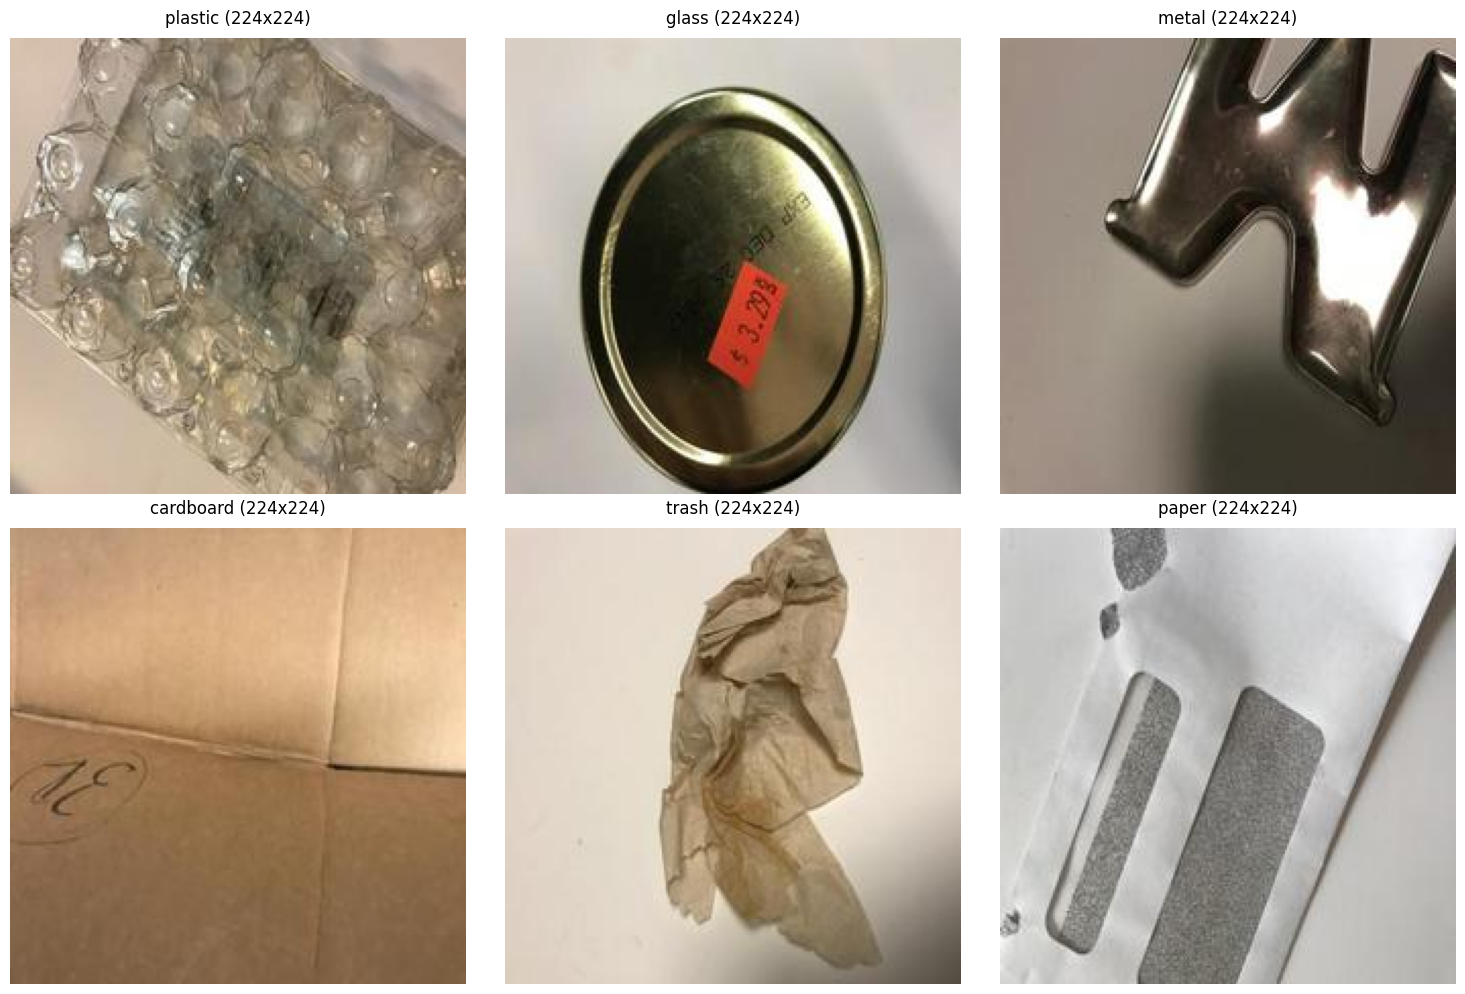

: 

In [2]:
# Split data into train/validation/test sets
from sklearn.model_selection import train_test_split

# First split: 70% train, 30% temp (which will be split into val and test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['category'])

# Second split: Split temp into validation and test (50% each of the remaining 30%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['category'])

print("Data split sizes:")
print(f"Training set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Function to resize and preprocess images
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size, Image.Resampling.LANCZOS)
    img = img.convert('RGB')  # Ensure image is in RGB format
    return img

# Create directories for processed images
processed_base = Path('data/processed')
for split in ['train', 'val', 'test']:
    (processed_base / split).mkdir(parents=True, exist_ok=True)
    for category in df['category'].unique():
        (processed_base / split / category).mkdir(parents=True, exist_ok=True)

# Process and save images for each split
def process_and_save_split(split_df, split_name):
    for idx, row in split_df.iterrows():
        # Get the image and category
        img = preprocess_image(row['image_path'])
        category = row['category']
        
        # Create new filename
        new_filename = f"{idx}_{Path(row['image_path']).name}"
        save_path = processed_base / split_name / category / new_filename
        
        # Save the processed image
        img.save(save_path)

# Process all splits
print("\nProcessing images...")
process_and_save_split(train_df, 'train')
process_and_save_split(val_df, 'val')
process_and_save_split(test_df, 'test')
print("Image processing complete!")

# Display sample of processed images
plt.figure(figsize=(15, 10))
for idx, category in enumerate(df['category'].unique()):
    # Get the first processed image path for this category
    processed_path = next((processed_base / 'train' / category).glob('*.jpg'))
    
    plt.subplot(2, 3, idx + 1)
    img = Image.open(processed_path)
    plt.imshow(img)
    plt.title(f"{category} (224x224)", fontsize=12, pad=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

### Transfer Learning Setup
Choose a pre-trained model:

MobileNetV2 (fast, lightweight) or EfficientNetB0 (better accuracy).

Freeze base model:

Add custom layers:





In [3]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import tensorflow as tf

# Resnet50

from tensorflow.keras.applications import ResNet50
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# freeze at custom layers

base_model.trainable = False

# add new layers to the basel model from MobileNetV2

""" model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 clases
])
 """
# Arquitectura mejorada
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),  # Más neuronas para mejor capacidad
    layers.BatchNormalization(),          # Estabiliza el entrenamiento
    layers.Dropout(0.5),                 # Mayor dropout para evitar overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')  # 6 categorías
])

2025-06-04 11:58:14.005531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


: 

: 

#### **3. Training Pipeline**  
**Data Augmentation**:  


2025-06-04 11:42:38.432146: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 11:42:38.435718: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 11:42:38.541068: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 11:42:38.544342: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 11:42:38.545602: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 11:42:38.546570: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 11:42:38.547859: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 11:42:38.548966: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 11:42:38.550082: I tensorflow/core/common_runtime/gpu_fusion_pass.cc:508] ROCm Fusion is enabled.
2025-06-04 11:42:38

UnknownError: Exception encountered when calling layer 'random_rotation' (type RandomRotation).

{{function_node __wrapped__Neg_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Neg] name: 

Call arguments received by layer 'random_rotation' (type RandomRotation):
  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)
  • training=True

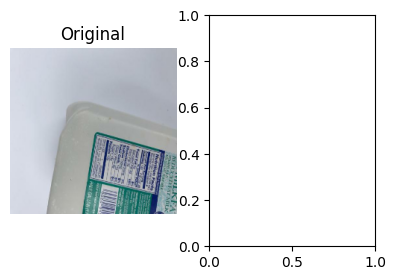

: 

: 

: 

In [ ]:
# Data Augmentation Setup
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomTranslation(0.2, 0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal"),
])


def load_and_preprocess_image(image_path, label, augment=True):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32)  # [0, 255]
    if augment:
        img = tf.expand_dims(img, axis=0)
        img = data_augmentation(img, training=True)
        img = tf.squeeze(img, axis=0)
        img = tf.image.random_brightness(img, max_delta=0.2)
        img = tf.image.random_contrast(img, lower=0.8, upper=1.2)
        img = tf.clip_by_value(img, 0.0, 255.0)  # Ensure valid range for preprocess_input
    img = preprocess_input(img)  # ResNet preprocessing
    return img, label

def create_dataset(df, augment=True, batch_size=16):
    image_paths = df['image_path'].values
    labels = df['category'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(
        lambda x, y: load_and_preprocess_image(x, y, augment),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = create_dataset(train_df, augment=True)
val_dataset = create_dataset(val_df, augment=False)
test_dataset = create_dataset(test_df, augment=False)

def visualize_augmentation(image_path, num_samples=5):
    plt.figure(figsize=(15, 3))
    # Original image
    plt.subplot(1, num_samples + 1, 1)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.cast(img, tf.float32) / 255.0
    plt.imshow(img)
    plt.title('Original')
    plt.axis('off')
    # Augmented images
    for i in range(num_samples):
        plt.subplot(1, num_samples + 1, i + 2)
        aug_img = tf.expand_dims(img, axis=0)
        aug_img = data_augmentation(aug_img, training=True)
        aug_img = tf.squeeze(aug_img, axis=0)
        plt.imshow(aug_img)
        plt.title(f'Augmented {i+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage of visualization
sample_image_path = train_df['image_path'].iloc[0]
visualize_augmentation(sample_image_path)

model = models.Sequential([
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

*** Compile & Train***

In [ ]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import kagglehub
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import ResNet50
""" from tensorflow.keras.preprocessing.image import ImageDataGenerator """

# Set up matplotlib for better visualization
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]

# Download the dataset using kagglehub
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")
print("Path to dataset files:", path)

# Define the base path to the dataset
base_path = Path(path) / 'Garbage classification'

# Create lists to store the data
image_paths = []
categories = []

# Walk through the directory and collect all image paths and their categories
for category in os.listdir(base_path):
    category_path = base_path / category
    if os.path.isdir(category_path):
        for image_file in os.listdir(category_path):
            if image_file.endswith('.jpg'):
                image_paths.append(str(category_path / image_file))
                categories.append(category)

# Create the DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'category': categories
})

# Convert categories to numerical labels
category_to_label = {category: idx for idx, category in enumerate(df['category'].unique())}
df['label'] = df['category'].map(category_to_label)

# Split the data into train and validation sets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['category'])

# Data preprocessing
def preprocess_image(image_path, label):
    # Read the image file
    img = tf.io.read_file(image_path)
    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize the image
    img = tf.image.resize(img, [224, 224])
    # Normalize the image
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['image_path'].values, train_df['label'].values))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_df['image_path'].values, val_df['label'].values))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Create the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(category_to_label), activation='softmax')
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Save the model
model.save('waste_classification_model.h5')

Path to dataset files: /home/dtorrero/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

#### **4. Evaluation & Improvement**  
- **Plot training curves** (loss/accuracy) to check for overfitting.  





 

 **Test on unseen data**: Evaluate on `test_df`.  

#### **5. Deployment (Optional)**  
*** TBD ***

---

### **Key Considerations**  
- **Class Balance**: Ensure no class dominates (use `stratify` in train-test split).  
- **Image Size**: Standardize all images to the input size of your model.  
- **Augmentation**: Crucial for small datasets to prevent overfitting.  

---

### **Expected Results**  
With transfer learning + augmentation, aim for:  
- **Validation Accuracy**: 85%+  
- **Test Accuracy**: Within 5% of validation accuracy.